In [ ]:
# Imported the required libraries
from pyspark.sql import SparkSession
from pyspark.sql import SparkSession
from pyspark.sql import functions as fun
from pyspark.sql.window import Window
from pyspark.ml.feature import MinMaxScaler, VectorAssembler, StringIndexer
from pyspark.sql.functions import col





In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


In [ ]:
# Initialization of SparkApache
spark = SparkSession.builder.appName("LifeExpectancyAnalysis").config("spark.some.config.option", "some-value").getOrCreate()

In [ ]:
Path_file = "/content/Life Expectancy Data.csv"
# Loading dataset
df=spark.read.csv(Path_file, header=True, inferSchema=True)
# Displaying the schema
df.printSchema()
# Displaying the first few rows
df.show(5)
# Displaying the statistics
df2=df.describe()
df2.show()

root
 |-- Country: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Status: string (nullable = true)
 |-- Life expectancy : double (nullable = true)
 |-- Adult Mortality: integer (nullable = true)
 |-- infant deaths: integer (nullable = true)
 |-- Alcohol: double (nullable = true)
 |-- percentage expenditure: double (nullable = true)
 |-- Hepatitis B: integer (nullable = true)
 |-- Measles : integer (nullable = true)
 |--  BMI : double (nullable = true)
 |-- under-five deaths : integer (nullable = true)
 |-- Polio: integer (nullable = true)
 |-- Total expenditure: double (nullable = true)
 |-- Diphtheria : integer (nullable = true)
 |--  HIV/AIDS: double (nullable = true)
 |-- GDP: double (nullable = true)
 |-- Population: double (nullable = true)
 |--  thinness  1-19 years: double (nullable = true)
 |--  thinness 5-9 years: double (nullable = true)
 |-- Income composition of resources: double (nullable = true)
 |-- Schooling: double (nullable = true)

+-----------+--

Data Cleaning and Pre Processing


In [ ]:
# 1)removing Duplicates
spark_df= df.dropDuplicates()

In [ ]:
# 2)Missing value handling using mean for filling

#EMPTY LIST
num_list = []
# Iterate throughout the dataframe
for i, j in spark_df.dtypes:
    # Check if the column type is numeric
    if j in ['int', 'double', 'float']:
        num_list.append(i)



In [ ]:
for i in num_list:
    mean_value = spark_df.select(fun.mean(fun.col(i))).first()[0]
    spark_df = spark_df.fillna({i: mean_value})

In [ ]:
spark_df.show(10)

+------------+----+----------+----------------+---------------+-------------+-------+----------------------+-----------+--------+-----+------------------+-----+-----------------+-----------+---------+-----------+-----------+---------------------+-------------------+-------------------------------+---------+
|     Country|Year|    Status|Life expectancy |Adult Mortality|infant deaths|Alcohol|percentage expenditure|Hepatitis B|Measles | BMI |under-five deaths |Polio|Total expenditure|Diphtheria | HIV/AIDS|        GDP| Population| thinness  1-19 years| thinness 5-9 years|Income composition of resources|Schooling|
+------------+----+----------+----------------+---------------+-------------+-------+----------------------+-----------+--------+-----+------------------+-----+-----------------+-----------+---------+-----------+-----------+---------------------+-------------------+-------------------------------+---------+
| Afghanistan|2015|Developing|            65.0|            263|          

In [ ]:
# Renaming the columns (removing the spaces)
# Empty list
re_col = []
# Iterating the all column names
for k in spark_df.columns:
    # removing spaces and replacing with underscrolls
    renamed_col = col(k).alias(k.strip().replace(" ", "_"))
    re_col.append(renamed_col)
# Seeting the remaned names of columns in DF
spark_df = spark_df.select(re_col)
#displaying to verify
print(spark_df.columns)


['Country', 'Year', 'Status', 'Life_expectancy', 'Adult_Mortality', 'infant_deaths', 'Alcohol', 'percentage_expenditure', 'Hepatitis_B', 'Measles', 'BMI', 'under-five_deaths', 'Polio', 'Total_expenditure', 'Diphtheria', 'HIV/AIDS', 'GDP', 'Population', 'thinness__1-19_years', 'thinness_5-9_years', 'Income_composition_of_resources', 'Schooling']


In [ ]:
con_cols = ['Life_expectancy','Alcohol','BMI','percentage_expenditure']
assemb = VectorAssembler(inputCols=con_cols,outputCol="feature_vectors")
scaling = MinMaxScaler(inputCol="feature_vectors",outputCol="features_scaled")

In [ ]:
assem_data = assemb.transform(spark_df)
scaling_df = scaling.fit(assem_data).transform(assem_data)


In [ ]:
scaling_df.show(20)

+--------------------+----+----------+---------------+---------------+-------------+-------+----------------------+-----------+-------+----+-----------------+-----+-----------------+----------+--------+-----------+-----------+--------------------+------------------+-------------------------------+---------+--------------------+--------------------+
|             Country|Year|    Status|Life_expectancy|Adult_Mortality|infant_deaths|Alcohol|percentage_expenditure|Hepatitis_B|Measles| BMI|under-five_deaths|Polio|Total_expenditure|Diphtheria|HIV/AIDS|        GDP| Population|thinness__1-19_years|thinness_5-9_years|Income_composition_of_resources|Schooling|     feature_vectors|     features_scaled|
+--------------------+----+----------+---------------+---------------+-------------+-------+----------------------+-----------+-------+----+-----------------+-----+-----------------+----------+--------+-----------+-----------+--------------------+------------------+-------------------------------+

In [ ]:
# 4. Filtering the Outliers
# deleting the rows for "Life Expectancy" that have values greater than three standard deviations from the mean.
sd = spark_df.select(fun.stddev("Life_expectancy")).first()[0]
mean_s = spark_df.select(fun.mean("Life_expectancy")).first()[0]
spark_df = spark_df.filter((fun.col("Life_expectancy") >= mean_s - 3 * sd) & (fun.col("Life_expectancy") <= mean_s + 3 * sd)
)

In [ ]:
spark_df.show(10)

+------------+----+----------+---------------+---------------+-------------+-------+----------------------+-----------+-------+----+-----------------+-----+-----------------+----------+--------+-----------+-----------+--------------------+------------------+-------------------------------+---------+
|     Country|Year|    Status|Life_expectancy|Adult_Mortality|infant_deaths|Alcohol|percentage_expenditure|Hepatitis_B|Measles| BMI|under-five_deaths|Polio|Total_expenditure|Diphtheria|HIV/AIDS|        GDP| Population|thinness__1-19_years|thinness_5-9_years|Income_composition_of_resources|Schooling|
+------------+----+----------+---------------+---------------+-------------+-------+----------------------+-----------+-------+----+-----------------+-----+-----------------+----------+--------+-----------+-----------+--------------------+------------------+-------------------------------+---------+
| Afghanistan|2015|Developing|           65.0|            263|           62|   0.01|           71

In [ ]:
# 5. Transforming feature using log
# for skewed columns like "Measles" (adding 1 for avoiding log(0))
spark_df = spark_df.withColumn("log_measles", fun.log(fun.col("Measles") + 1))

In [ ]:
spark_df.show(10)

+------------+----+----------+---------------+---------------+-------------+-------+----------------------+-----------+-------+----+-----------------+-----+-----------------+----------+--------+-----------+-----------+--------------------+------------------+-------------------------------+---------+------------------+
|     Country|Year|    Status|Life_expectancy|Adult_Mortality|infant_deaths|Alcohol|percentage_expenditure|Hepatitis_B|Measles| BMI|under-five_deaths|Polio|Total_expenditure|Diphtheria|HIV/AIDS|        GDP| Population|thinness__1-19_years|thinness_5-9_years|Income_composition_of_resources|Schooling|       log_measles|
+------------+----+----------+---------------+---------------+-------------+-------+----------------------+-----------+-------+----+-----------------+-----+-----------------+----------+--------+-----------+-----------+--------------------+------------------+-------------------------------+---------+------------------+
| Afghanistan|2015|Developing|          

In [ ]:
# 6. Encoding the Data for the type categorical
# For country string indexer is applied
index_r = StringIndexer(inputCol="Country", outputCol="Country_Indexed")
spark_df = index_r.fit(spark_df).transform(spark_df)

In [ ]:
spark_df.show(10)

+------------+----+----------+---------------+---------------+-------------+-------+----------------------+-----------+-------+----+-----------------+-----+-----------------+----------+--------+-----------+-----------+--------------------+------------------+-------------------------------+---------+------------------+---------------+
|     Country|Year|    Status|Life_expectancy|Adult_Mortality|infant_deaths|Alcohol|percentage_expenditure|Hepatitis_B|Measles| BMI|under-five_deaths|Polio|Total_expenditure|Diphtheria|HIV/AIDS|        GDP| Population|thinness__1-19_years|thinness_5-9_years|Income_composition_of_resources|Schooling|       log_measles|Country_Indexed|
+------------+----+----------+---------------+---------------+-------------+-------+----------------------+-----------+-------+----+-----------------+-----+-----------------+----------+--------+-----------+-----------+--------------------+------------------+-------------------------------+---------+------------------+---------

In [ ]:
# 7.winnowing for data aggragation
# Calculatinf life expentancy with country
window_spec = Window.partitionBy("Country")
spark_df = spark_df.withColumn("avg_life_expectancy_country",fun.mean("Life_expectancy").over(window_spec))

In [ ]:
spark_df.show(5)

+-----------+----+----------+---------------+---------------+-------------+-------+----------------------+-----------+-------+----+-----------------+-----+-----------------+----------+--------+-----------+-----------+--------------------+------------------+-------------------------------+---------+------------------+---------------+---------------------------+
|    Country|Year|    Status|Life_expectancy|Adult_Mortality|infant_deaths|Alcohol|percentage_expenditure|Hepatitis_B|Measles| BMI|under-five_deaths|Polio|Total_expenditure|Diphtheria|HIV/AIDS|        GDP| Population|thinness__1-19_years|thinness_5-9_years|Income_composition_of_resources|Schooling|       log_measles|Country_Indexed|avg_life_expectancy_country|
+-----------+----+----------+---------------+---------------+-------------+-------+----------------------+-----------+-------+----+-----------------+-----+-----------------+----------+--------+-----------+-----------+--------------------+------------------+-----------------

In [ ]:
# Feature Columns assignment
feat_colss = ['Adult_Mortality', 'infant_deaths', 'Alcohol', 'percentage_expenditure',
                   'BMI', 'under-five_deaths', 'Polio', 'Total_expenditure', 'Diphtheria',
                   'HIV/AIDS', 'thinness__1-19_years', 'thinness_5-9_years',
                   'Income_composition_of_resources', 'Schooling']

# Assembling the feature as before
assemb = VectorAssembler(inputCols=feat_colss,outputCol="features")
pred_data = assemb.transform(spark_df).select("features", "Life_expectancy")


In [ ]:
# SPlitting into training and testing
trained_data, tested_data = pred_data.randomSplit([0.8, 0.2],seed=42)

In [ ]:
import matplotlib.pyplot as plt
from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.classification import LogisticRegression

Linear Regression model


In [ ]:
linear = LinearRegression(featuresCol="features", labelCol="Life_expectancy")
#fitting
linear_mod = linear.fit(trained_data)
#transforming
linear_pred = linear_mod.transform(tested_data)




In [ ]:
# Evaluation
eval = RegressionEvaluator(labelCol="Life_expectancy", predictionCol="prediction")
linear_rmse = eval.evaluate(linear_pred, {eval.metricName: "rmse"})
linear_r2 = eval.evaluate(linear_pred, {eval.metricName: "r2"})
print(f"LinearRegression Model:RMSE:{linear_rmse},Rsquared: {linear_r2}")

LinearRegression Model:RMSE:4.156545713631285,Rsquared: 0.8149036079221492


Random FOrest Model


In [ ]:
randf = RandomForestRegressor(featuresCol="features", labelCol="Life_expectancy")
randf_mod = randf.fit(trained_data)
randf_pred = randf_mod.transform(tested_data)



In [ ]:
# Evaluate
randf_rmse = eval.evaluate(randf_pred, {eval.metricName: "rmse"})
randf_r2 = eval.evaluate(randf_pred, {eval.metricName: "r2"})
print(f"Random ForestModel -RMSE:{randf_rmse},Rsqaured: {randf_r2}")

Random ForestModel -RMSE:2.8162381397437977,Rsqaured: 0.9150288330702034


Gradient Boosting Model

In [ ]:
gradbt = GBTRegressor(featuresCol="features", labelCol="Life_expectancy", maxIter=10)
gradbt_mod = gradbt.fit(trained_data)
gradbt_pred = gradbt_mod.transform(tested_data)




In [ ]:
# Evaluation
gradbt_rmse = eval.evaluate(gradbt_pred, {eval.metricName: "rmse"})
gradbt_r2 = eval.evaluate(gradbt_pred, {eval.metricName: "r2"})
print(f"Gradient Boosted Trees Model - RMSE: {gradbt_rmse}, Rsquared: {gradbt_r2}")

Gradient Boosted Trees Model - RMSE: 2.6918560799827445, Rsquared: 0.9223687633730367


Decision Tree Regression model

In [ ]:
dft = DecisionTreeRegressor(featuresCol="features", labelCol="Life_expectancy")
dft_mod = dft.fit(trained_data)
dft_pred = dft_mod.transform(tested_data)

In [ ]:
# Evaluate
dft_rmse = eval.evaluate(dft_pred, {eval.metricName: "rmse"})
dft_r2 = eval.evaluate(dft_pred, {eval.metricName: "r2"})
print(f"Decision Tree -RMSE: {dft_rmse},Rsquared: {dft_r2}")

Decision Tree -RMSE: 3.1840643302239497,Rsquared: 0.8913833264415228


Lasso Regression mODel

In [ ]:
lasso_reg = LinearRegression(featuresCol="features", labelCol="Life_expectancy", regParam=0.1, elasticNetParam=1.0)
lasso_reg_mod= lasso_reg.fit(trained_data)
lasso_reg_pred = lasso_reg_mod.transform(tested_data)




In [ ]:
#evaluation
eval = RegressionEvaluator(labelCol="Life_expectancy", predictionCol="prediction")
lasso_reg_rmse = eval.evaluate(lasso_reg_pred, {eval.metricName: "rmse"})
lasso_reg_r2 = eval.evaluate(lasso_reg_pred, {eval.metricName: "r2"})
print(f"LassoRegression model-RMSE: {lasso_reg_rmse},RsquaRED: {lasso_reg_r2}")

LassoRegression model-RMSE: 4.285480914508594,RsquaRED: 0.8032421983219803


In [ ]:
# Making a categorization task: Life Expectancy: High (>70) vs. Low (<=70)
data_class = pred_data.withColumn("LifeExpectancyClass",fun.when(fun.col("Life_expectancy") > 70, 1).otherwise(0))
# Splitting Training-Testing for classification
trained_data_class, tested_data_class = data_class.randomSplit([0.8, 0.2], seed=42)
linear_class = LogisticRegression(featuresCol="features", labelCol="LifeExpectancyClass")
linear_class_mod = linear_class.fit(trained_data_class)
linear_class_pred = linear_class_mod.transform(tested_data_class)




In [ ]:
# Evaluate Classification
eval_class = MulticlassClassificationEvaluator(labelCol="LifeExpectancyClass",predictionCol="prediction",metricName="accuracy")
accur = eval_class.evaluate(linear_class_pred)
# Precision
eval_pred = MulticlassClassificationEvaluator(labelCol="LifeExpectancyClass",predictionCol="prediction",
    metricName="weightedPrecision")
precis = eval_pred.evaluate(linear_class_pred)
# Recall
eval_recall = MulticlassClassificationEvaluator(labelCol="LifeExpectancyClass",predictionCol="prediction",metricName="weightedRecall")
recall_l = eval_recall.evaluate(linear_class_pred)
# F1_Score
eval_f1 = MulticlassClassificationEvaluator(labelCol="LifeExpectancyClass",
          predictionCol="prediction",metricName="f1")





scores_f1 = eval_f1.evaluate(linear_class_pred)

In [ ]:
# Print Metrics
print(f"LogisticRegression Classification  Model- Accuracy: {accur}")
print(f"LogisticRegression Classification  Model- Precision: {precis}")
print(f"LogisticRegression Classification  Model - Recall: {recall_l}")
print(f"LogisticRegression Classification  Model - F1 Score: {scores_f1}")

LogisticRegression Classification  Model- Accuracy: 0.9158878504672897
LogisticRegression Classification  Model- Precision: 0.9168340881941472
LogisticRegression Classification  Model - Recall: 0.9158878504672898
LogisticRegression Classification  Model - F1 Score: 0.9156291454139475


In [ ]:
# Metric exmaples for regressionmodles
metric_allmodels = {"Model": ["Linear Regression", "Random Forest", "Gradient Boosting", "Decision Tree", "Lasso Regression"],

        "RMSE": [linear_rmse, randf_rmse, gradbt_rmse, dft_rmse, lasso_reg_rmse],

                    "Rsquared": [linear_r2, randf_r2, gradbt_r2, dft_r2, lasso_reg_r2]}



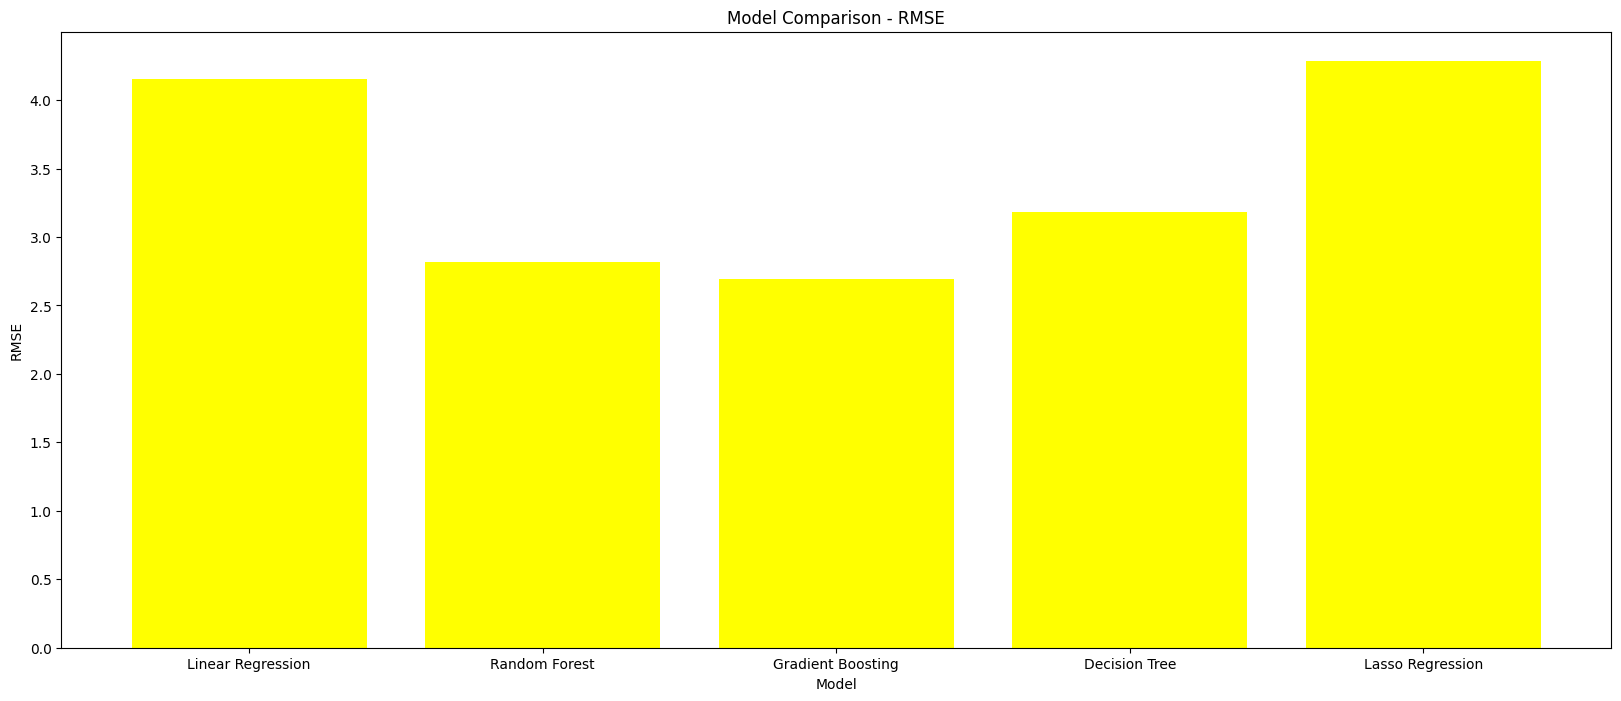

In [ ]:
# Creating a new data frame using pandas as pd
import pandas as pd
m_df = pd.DataFrame(metric_allmodels)
# plotting bar for RMSE
plt.figure(figsize=(20,8))
plt.bar(m_df["Model"], m_df["RMSE"], color='yellow')
plt.title("Model Comparison - RMSE")
plt.xlabel("Model")
plt.ylabel("RMSE")
plt.show()


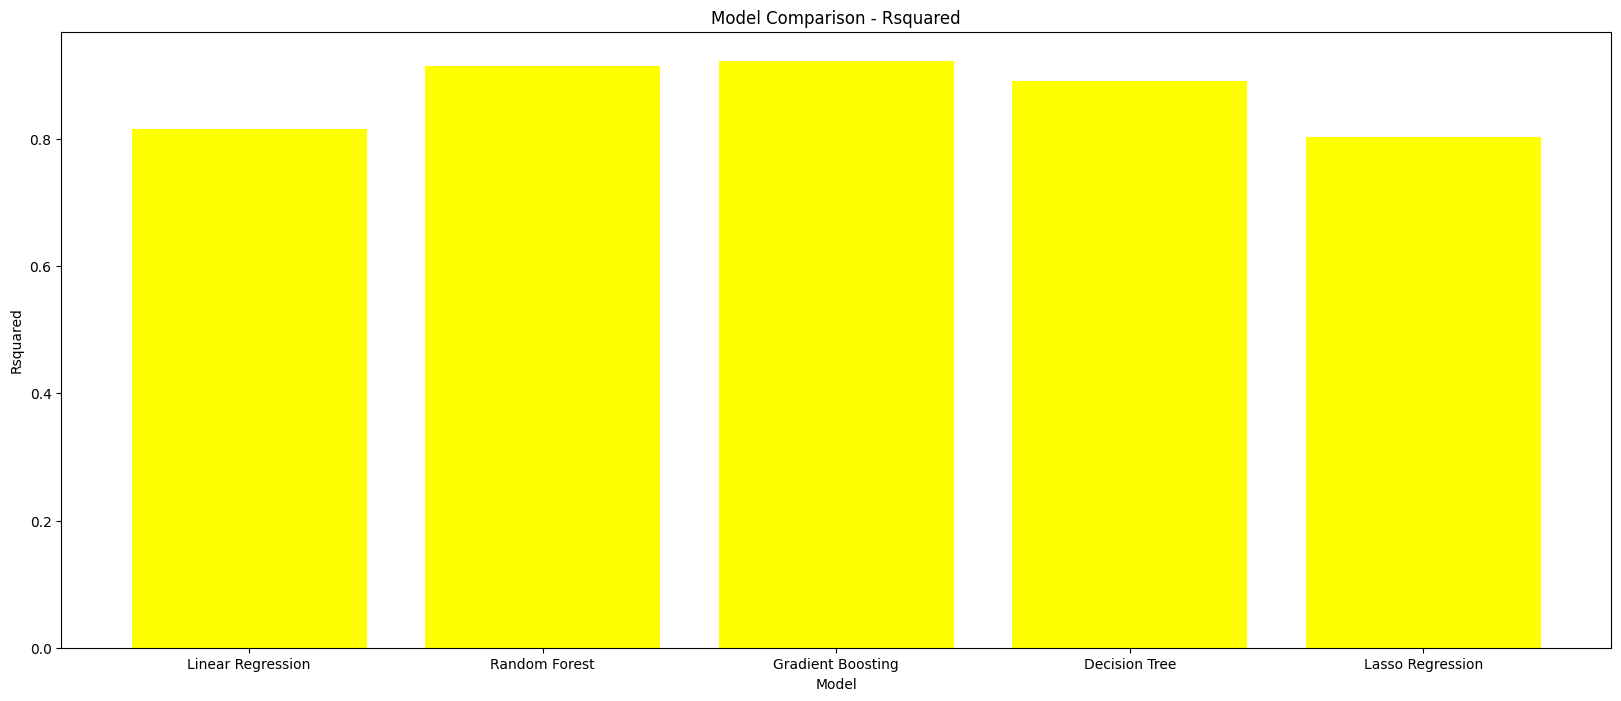

In [ ]:
# plotting bar for Rsquared
plt.figure(figsize=(20,8))
plt.bar(m_df["Model"], m_df["Rsquared"], color='yellow')
plt.title("Model Comparison - Rsquared")
plt.xlabel("Model")
plt.ylabel("Rsquared")
plt.show()

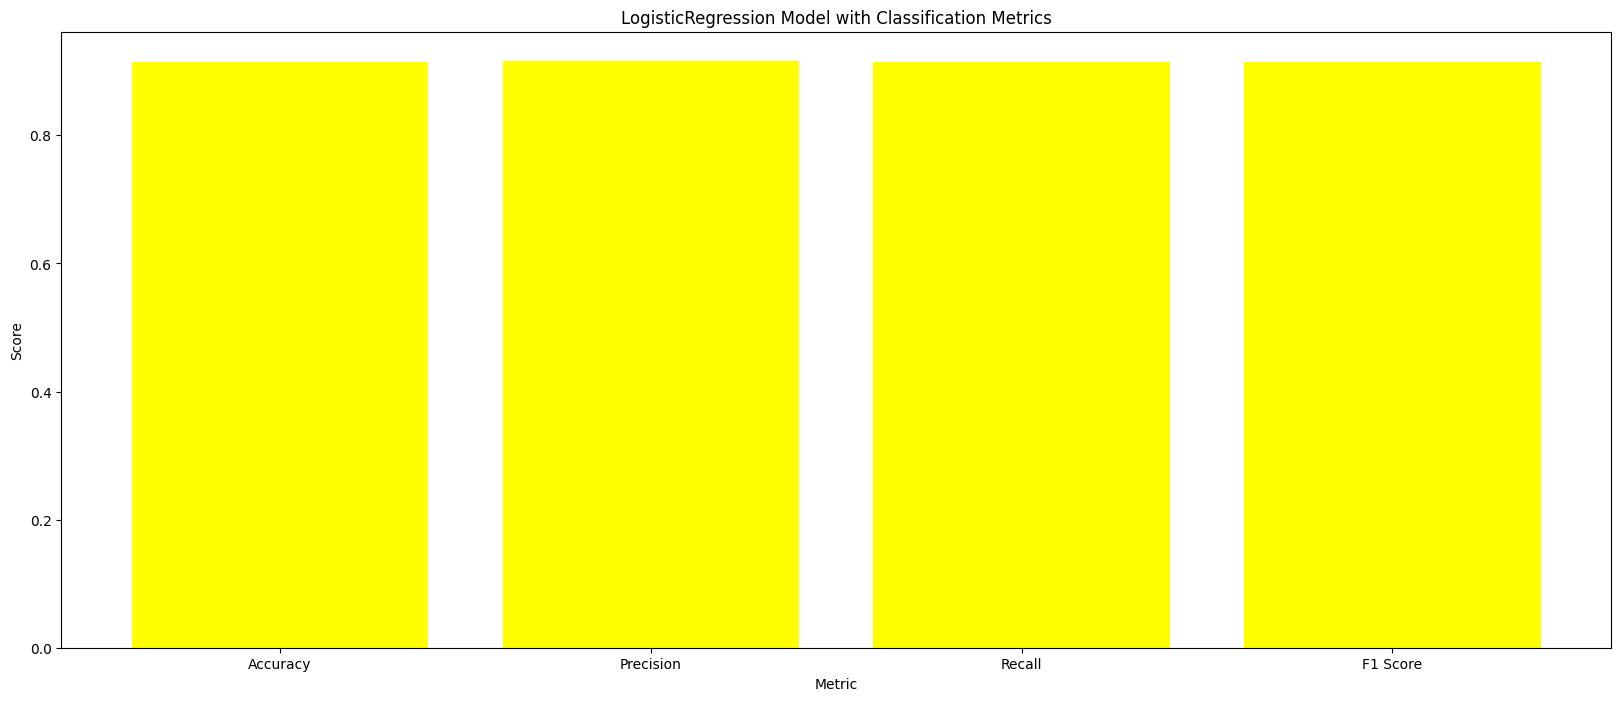

In [ ]:
class_metric = {"Metric": ["Accuracy", "Precision", "Recall", "F1 Score"],"Logistic Regression": [0.915,0.916,0.915,0.915]}
# Creating new DataFrame
class_df = pd.DataFrame(class_metric)
# plotting bar graph for Classification Metrics
plt.figure(figsize=(20,8))
plt.bar(class_df["Metric"], class_df["Logistic Regression"], color='yellow')
plt.title("LogisticRegression Model with Classification Metrics")
plt.xlabel("Metric")
plt.ylabel("Score")
plt.show()

In [ ]:
!pip install pyngrok

In [ ]:
from pyngrok import ngrok
!ngrok config add-authtoken 2ooh2ZHelN695sMzArOpUvHTumy_3DqQfFYdHnab23jjr4RFi
url_pub = ngrok.connect(4040)
print(f"SparkUI can be accessed here using: {url_pub}")

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


SparkUI can be accessed here using: NgrokTunnel: "https://131c-34-125-156-246.ngrok-free.app" -> "http://localhost:4040"
